# %% [markdown]
# # Notebook 8: Customer Behavior Analysis
# ## Bati Bank - RFM Analysis & Customer Segmentation
# 
# **Objective:** Analyze customer behavior patterns for credit risk assessment
# **Focus:** RFM segmentation, customer lifetime value, behavioral risk indicators
# 
# ### Basel II Requirements Addressed:
# 1. Customer segmentation for risk differentiation
# 2. Behavioral scoring development
# 3. Customer concentration risk assessment

# %% [markdown]
# ## 1. Setup & Configuration

In [1]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Banking-specific styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
corporate_colors = ['#003366', '#0066CC', '#0099FF', '#00CCFF', '#66CCFF']
risk_colors = ['#2E8B57', '#FFD700', '#FF8C00', '#DC143C']

# Load data
df = pd.read_csv('../../data/processed/cleaned_data.csv')
print(f"📊 Dataset loaded: {df.shape[0]:,} transactions, {df.shape[1]} features")

# Ensure datetime column exists
if 'TransactionStartTime' in df.columns:
    if not pd.api.types.is_datetime64_any_dtype(df['TransactionStartTime']):
        df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])
    
# Check for required columns
required_cols = ['CustomerId', 'TransactionStartTime', 'Amount']
if all(col in df.columns for col in required_cols):
    print("✅ Required columns available for RFM analysis")
else:
    missing = [col for col in required_cols if col not in df.columns]
    print(f"⚠️ Missing columns: {missing}")

📊 Dataset loaded: 95,662 transactions, 21 features
✅ Required columns available for RFM analysis


# %% [markdown]
# ## 2. RFM Analysis (Recency, Frequency, Monetary)

RFM ANALYSIS - CUSTOMER BEHAVIOR SEGMENTATION

📅 RFM Calculation Snapshot Date: 2019-02-14
------------------------------------------------------------
📊 RFM Statistics:
----------------------------------------
Total customers analyzed: 3,742

Recency (days since last transaction):
  Mean: 31.5 days
  Median: 25.0 days
  Range: 1 to 91 days

Frequency (total transactions):
  Mean: 25.6
  Median: 7.0
  Range: 1 to 4091

Monetary (total amount spent):
  Mean: $171,737.74
  Median: $20,000.00
  Range: $-104,900,000.00 to $83,451,240.00


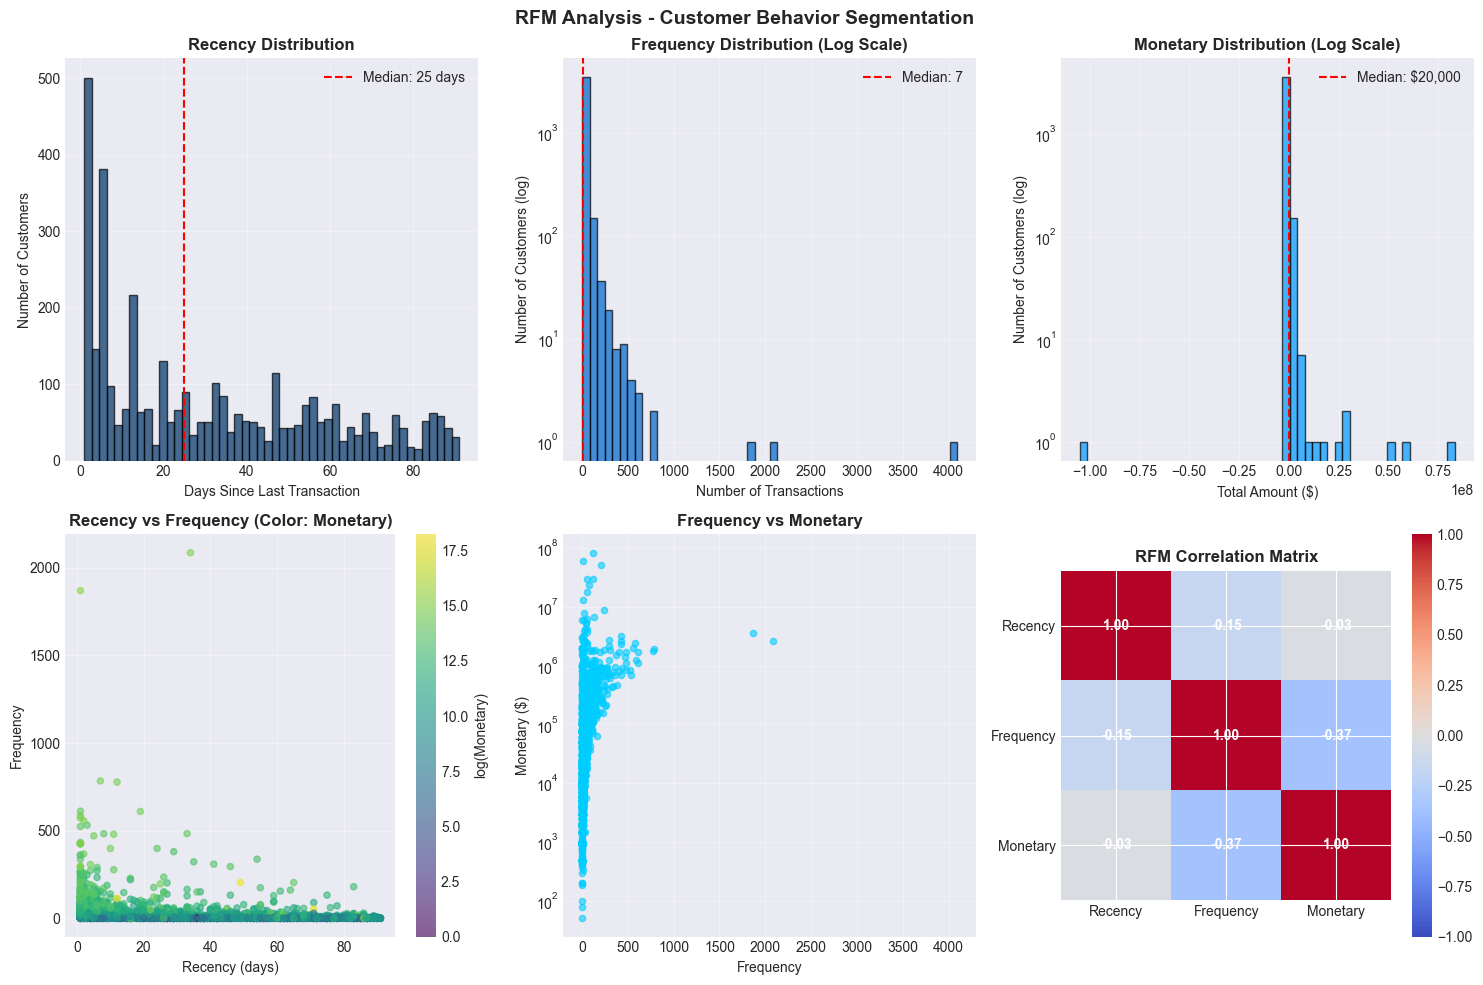

In [5]:
# %%
print("="*80)
print("RFM ANALYSIS - CUSTOMER BEHAVIOR SEGMENTATION")
print("="*80)

def calculate_rfm(df, snapshot_date=None):
    """Calculate RFM metrics for each customer"""
    
    if snapshot_date is None:
        snapshot_date = df['TransactionStartTime'].max() + pd.Timedelta(days=1)
    
    print(f"\n📅 RFM Calculation Snapshot Date: {snapshot_date.date()}")
    print("-" * 60)
    
    # Calculate RFM metrics - CORRECTED VERSION
    rfm = df.groupby('CustomerId').agg({
        'TransactionStartTime': [
            ('Recency', lambda x: (snapshot_date - x.max()).days),
            ('Frequency', 'count')
        ],
        'Amount': [
            ('Monetary', 'sum')
        ]
    })
    
    # Flatten the multi-level columns
    rfm.columns = ['Recency', 'Frequency', 'Monetary']
    
    # Log transform for Monetary (often skewed)
    rfm['Monetary_log'] = np.log1p(rfm['Monetary'])
    
    print(f"📊 RFM Statistics:")
    print("-" * 40)
    print(f"Total customers analyzed: {len(rfm):,}")
    print(f"\nRecency (days since last transaction):")
    print(f"  Mean: {rfm['Recency'].mean():.1f} days")
    print(f"  Median: {rfm['Recency'].median():.1f} days")
    print(f"  Range: {rfm['Recency'].min():.0f} to {rfm['Recency'].max():.0f} days")
    
    print(f"\nFrequency (total transactions):")
    print(f"  Mean: {rfm['Frequency'].mean():.1f}")
    print(f"  Median: {rfm['Frequency'].median():.1f}")
    print(f"  Range: {rfm['Frequency'].min():.0f} to {rfm['Frequency'].max():.0f}")
    
    print(f"\nMonetary (total amount spent):")
    print(f"  Mean: ${rfm['Monetary'].mean():,.2f}")
    print(f"  Median: ${rfm['Monetary'].median():,.2f}")
    print(f"  Range: ${rfm['Monetary'].min():,.2f} to ${rfm['Monetary'].max():,.2f}")
    
    return rfm

# Calculate RFM
rfm_df = calculate_rfm(df)

# Create RFM visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Recency distribution
axes[0, 0].hist(rfm_df['Recency'], bins=50, color=corporate_colors[0], 
                edgecolor='black', alpha=0.7)
axes[0, 0].axvline(x=rfm_df['Recency'].median(), color='red', linestyle='--',
                  label=f'Median: {rfm_df["Recency"].median():.0f} days')
axes[0, 0].set_xlabel('Days Since Last Transaction')
axes[0, 0].set_ylabel('Number of Customers')
axes[0, 0].set_title('Recency Distribution', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Frequency distribution (log scale)
axes[0, 1].hist(rfm_df['Frequency'], bins=50, color=corporate_colors[1],
                edgecolor='black', alpha=0.7, log=True)
axes[0, 1].axvline(x=rfm_df['Frequency'].median(), color='red', linestyle='--',
                  label=f'Median: {rfm_df["Frequency"].median():.0f}')
axes[0, 1].set_xlabel('Number of Transactions')
axes[0, 1].set_ylabel('Number of Customers (log)')
axes[0, 1].set_title('Frequency Distribution (Log Scale)', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Monetary distribution (log scale)
axes[0, 2].hist(rfm_df['Monetary'], bins=50, color=corporate_colors[2],
                edgecolor='black', alpha=0.7, log=True)
axes[0, 2].axvline(x=rfm_df['Monetary'].median(), color='red', linestyle='--',
                  label=f'Median: ${rfm_df["Monetary"].median():,.0f}')
axes[0, 2].set_xlabel('Total Amount ($)')
axes[0, 2].set_ylabel('Number of Customers (log)')
axes[0, 2].set_title('Monetary Distribution (Log Scale)', fontsize=12, fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# 4. Recency vs Frequency scatter
scatter = axes[1, 0].scatter(rfm_df['Recency'], rfm_df['Frequency'],
                            c=rfm_df['Monetary_log'], s=20, alpha=0.6,
                            cmap='viridis')
axes[1, 0].set_xlabel('Recency (days)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Recency vs Frequency (Color: Monetary)', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 0], label='log(Monetary)')

# 5. Frequency vs Monetary scatter
axes[1, 1].scatter(rfm_df['Frequency'], rfm_df['Monetary'], s=20,
                  alpha=0.6, color=corporate_colors[3])
axes[1, 1].set_xlabel('Frequency')
axes[1, 1].set_ylabel('Monetary ($)')
axes[1, 1].set_title('Frequency vs Monetary', fontsize=12, fontweight='bold')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(alpha=0.3)

# 6. RFM correlation heatmap
correlation_matrix = rfm_df[['Recency', 'Frequency', 'Monetary']].corr()
im = axes[1, 2].imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
axes[1, 2].set_xticks(range(3))
axes[1, 2].set_yticks(range(3))
axes[1, 2].set_xticklabels(['Recency', 'Frequency', 'Monetary'])
axes[1, 2].set_yticklabels(['Recency', 'Frequency', 'Monetary'])
axes[1, 2].set_title('RFM Correlation Matrix', fontsize=12, fontweight='bold')

# Add correlation values
for i in range(3):
    for j in range(3):
        text = axes[1, 2].text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                              ha='center', va='center', color='white',
                              fontweight='bold')

plt.colorbar(im, ax=axes[1, 2])

plt.suptitle('RFM Analysis - Customer Behavior Segmentation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../../reports/task2_eda/visualizations/customer_behavior/rfm_analysis.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## 3. Customer Segmentation using K-Means Clustering

CUSTOMER SEGMENTATION USING K-MEANS CLUSTERING

🎯 CUSTOMER SEGMENTATION ANALYSIS:
------------------------------------------------------------
🔍 CHECKING DATA QUALITY:
  Total records: 3,742
  NaN values: 192
  Infinite values: 0
  Records after cleaning: 3,550

🔍 DETERMINING OPTIMAL NUMBER OF CLUSTERS:
----------------------------------------


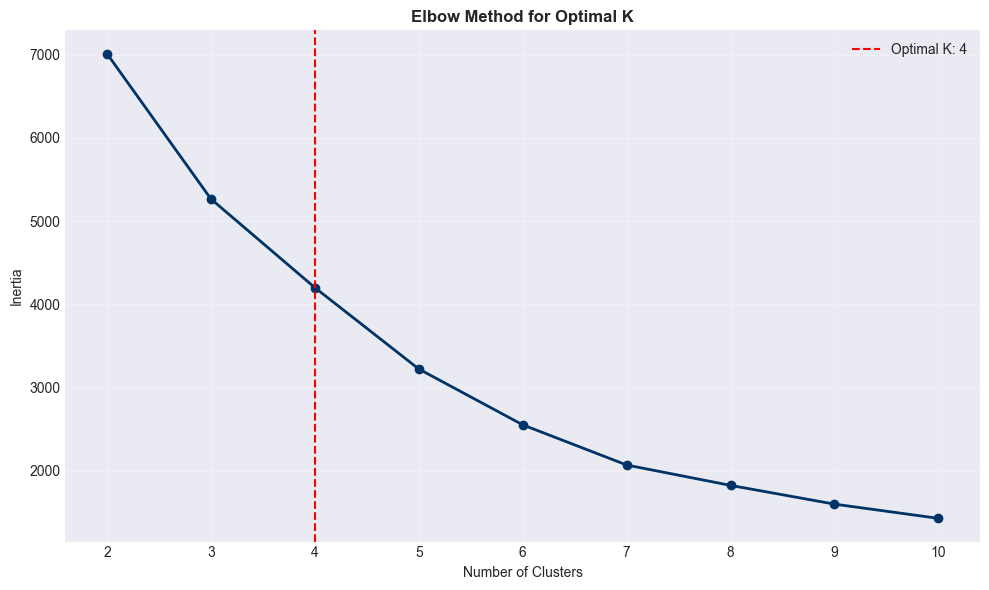

Recommended number of clusters: 4

📊 CLUSTER CHARACTERISTICS:
------------------------------------------------------------
Note: 192 customers could not be clustered (had NaN/Inf values)

Cluster 0 (n=1,119):
  Recency: 65.1 days avg
  Frequency: 6.7 transactions avg
  Monetary: $42,255.82 avg per customer
  Total value: $47,284,261

Cluster 1 (n=1,352):
  Recency: 12.1 days avg
  Frequency: 41.3 transactions avg
  Monetary: $468,673.79 avg per customer
  Total value: $633,646,966

Cluster 2 (n=47):
  Recency: 9.2 days avg
  Frequency: 464.3 transactions avg
  Monetary: $1,438,932.89 avg per customer
  Total value: $67,629,846

Cluster 3 (n=1,032):
  Recency: 19.8 days avg
  Frequency: 5.5 transactions avg
  Monetary: $9,532.35 avg per customer
  Total value: $9,837,389

🎯 CLUSTER INTERPRETATION:
----------------------------------------

Cluster 0 - At-Risk Customers:
  • 1,119 customers (29.9%)
  • Credit risk implication: High risk - Consider lower credit limits

Cluster 1 - Loyal Cu

In [8]:
# %%
print("="*80)
print("CUSTOMER SEGMENTATION USING K-MEANS CLUSTERING")
print("="*80)

# ... (keep the segment_customers function as corrected in previous response)

# Segment customers
rfm_df, cluster_labels, cluster_stats = segment_customers(rfm_df)

# Create cluster visualization - ONLY for classified customers
rfm_classified = rfm_df[rfm_df['Cluster'] != -1]

if len(rfm_classified) > 0:
    # Create subplots with correct specifications
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Cluster Distribution', 'RFM by Cluster',
                       'Cluster Value Contribution', 'PCA Visualization'),
        specs=[[{'type': 'domain'}, {'type': 'xy'}],
               [{'type': 'xy'}, {'type': 'scene'}]],
        vertical_spacing=0.15,
        horizontal_spacing=0.1
    )

    # 1. Cluster distribution pie chart
    cluster_counts = rfm_classified['Cluster'].value_counts().sort_index()
    cluster_names = [f"{cluster_labels[c]['label']}" for c in cluster_counts.index]
    cluster_colors = [cluster_labels[c]['color'] for c in cluster_counts.index]

    fig.add_trace(
        go.Pie(
            labels=cluster_names,
            values=cluster_counts.values,
            hole=0.4,
            marker_colors=cluster_colors,
            textinfo='label+percent',
            textposition='outside',
            showlegend=False
        ),
        row=1, col=1
    )

    # 2. RFM metrics by cluster (bar chart)
    clusters_sorted = sorted(rfm_classified['Cluster'].unique())
    
    for i, metric in enumerate(['Recency', 'Frequency', 'Monetary']):
        metric_values = []
        for cluster in clusters_sorted:
            cluster_data = rfm_classified[rfm_classified['Cluster'] == cluster]
            if metric == 'Monetary':
                # Use log scale for monetary
                value = np.log1p(cluster_data[metric].mean())
            else:
                value = cluster_data[metric].mean()
            metric_values.append(value)
        
        # Normalize for visualization
        metric_values = np.array(metric_values)
        if metric_values.max() > 0:
            metric_values = metric_values / metric_values.max()
        
        # Create x positions with offset for grouped bars
        x_positions = [f"Cluster {c}" for c in clusters_sorted]
        
        fig.add_trace(
            go.Bar(
                x=x_positions,
                y=metric_values,
                name=metric,
                marker_color=corporate_colors[i],
                showlegend=True
            ),
            row=1, col=2
        )
    
    # Update layout for subplot 1,2
    fig.update_xaxes(title_text="Clusters", row=1, col=2)
    fig.update_yaxes(title_text="Normalized Value", row=1, col=2)

    # 3. Cluster value contribution
    cluster_value = rfm_classified.groupby('Cluster')['Monetary'].sum()
    cluster_percentage = (cluster_value / cluster_value.sum()) * 100

    # Sort clusters for consistent ordering
    cluster_value = cluster_value.sort_index()
    
    fig.add_trace(
        go.Bar(
            x=[f"Cluster {c}" for c in cluster_value.index],
            y=cluster_value.values,
            marker_color=[cluster_labels[c]['color'] for c in cluster_value.index],
            text=[f'${v:,.0f}<br>({p:.1f}%)' for v, p in zip(cluster_value.values, cluster_percentage.values)],
            textposition='auto',
            showlegend=False
        ),
        row=2, col=1
    )
    
    fig.update_xaxes(title_text="Clusters", row=2, col=1)
    fig.update_yaxes(title_text="Total Monetary Value ($)", row=2, col=1)

    # 4. PCA Visualization (3D)
    # Prepare data for PCA
    rfm_pca_data = rfm_df.loc[rfm_classified.index, ['Recency', 'Frequency', 'Monetary_log']].dropna()
    
    if len(rfm_pca_data) > 0:
        rfm_scaled_pca = StandardScaler().fit_transform(rfm_pca_data)
        pca = PCA(n_components=3)
        pca_result = pca.fit_transform(rfm_scaled_pca)

        # Get cluster labels for PCA data
        pca_clusters = rfm_df.loc[rfm_pca_data.index, 'Cluster']
        
        fig.add_trace(
            go.Scatter3d(
                x=pca_result[:, 0],
                y=pca_result[:, 1],
                z=pca_result[:, 2],
                mode='markers',
                marker=dict(
                    size=5,
                    color=pca_clusters,
                    colorscale='Viridis',
                    opacity=0.7,
                    showscale=True
                ),
                text=[f"Cluster {c}" for c in pca_clusters],
                hoverinfo='text',
                showlegend=False
            ),
            row=2, col=2
        )
        
        # Update 3D scene
        fig.update_scenes(
            xaxis_title='PCA 1',
            yaxis_title='PCA 2', 
            zaxis_title='PCA 3',
            row=2, col=2
        )
    
    # Update overall layout
    fig.update_layout(
        title_text="Customer Segmentation Analysis Dashboard",
        height=800,
        showlegend=True,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ),
        margin=dict(t=100, b=50, l=50, r=50)
    )
    
    fig.show()
else:
    print("⚠️ No customers could be clustered. Check data quality.")

# %% [markdown]
# ## 4. Customer Lifetime Value (CLV) Analysis

CUSTOMER LIFETIME VALUE (CLV) ANALYSIS

💰 CUSTOMER LIFETIME VALUE ANALYSIS:
------------------------------------------------------------
📊 CLV STATISTICS:
----------------------------------------
Total customers analyzed: 3,742

Historical CLV (past spending):
  Mean: $171,737.74
  Median: $20,000.00
  Total: $642,642,626

Predicted CLV (future value):
  Mean: $1,477,666,335.91
  Median: $25,824,416.21
  Total: $5,529,427,428,966

CLV SEGMENTATION:
----------------------------------------

Low CLV Segment:
  Customers: 940 (25.1%)
  Avg Historical CLV: $-117,501.77
  Avg Predicted CLV: $-128,032,938.53
  Total Predicted Value: $-120,350,962,223

Medium CLV Segment:
  Customers: 931 (24.9%)
  Avg Historical CLV: $42,320.35
  Avg Predicted CLV: $7,139,216.53
  Total Predicted Value: $6,646,610,585

High CLV Segment:
  Customers: 935 (25.0%)
  Avg Historical CLV: $78,869.92
  Avg Predicted CLV: $150,544,253.85
  Total Predicted Value: $140,758,877,346

Very High CLV Segment:
  Customers: 

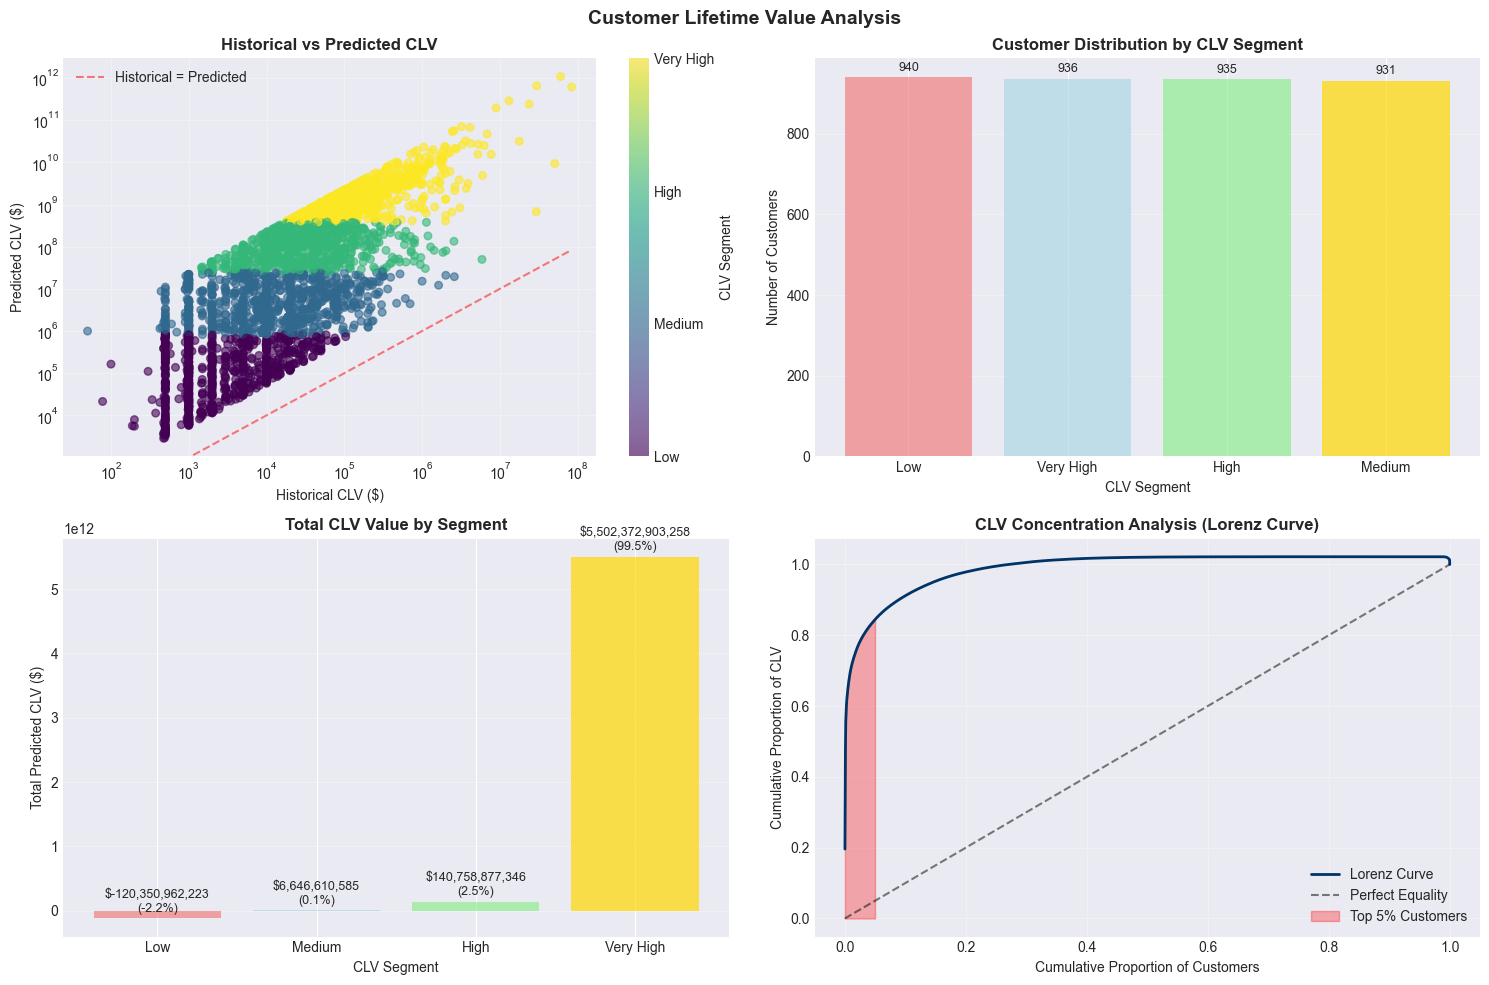

In [9]:
# %%
print("="*80)
print("CUSTOMER LIFETIME VALUE (CLV) ANALYSIS")
print("="*80)

def calculate_clv(df, rfm_df, prediction_months=12):
    """Calculate Customer Lifetime Value using RFM-based approach"""
    
    print(f"\n💰 CUSTOMER LIFETIME VALUE ANALYSIS:")
    print("-" * 60)
    
    # Calculate basic CLV metrics
    clv_data = rfm_df.copy()
    
    # 1. Historical CLV (past value)
    clv_data['Historical_CLV'] = clv_data['Monetary']
    
    # 2. Calculate average transaction value
    customer_transactions = df.groupby('CustomerId').agg({
        'Amount': ['count', 'mean', 'std']
    })
    customer_transactions.columns = ['transaction_count', 'avg_transaction_value', 'std_transaction_value']
    
    clv_data = clv_data.merge(customer_transactions, left_index=True, right_index=True, how='left')
    
    # 3. Calculate purchase frequency (transactions per month)
    # First, calculate customer tenure in months
    customer_tenure = df.groupby('CustomerId')['TransactionStartTime'].agg(['min', 'max'])
    customer_tenure['tenure_days'] = (customer_tenure['max'] - customer_tenure['min']).dt.days
    customer_tenure['tenure_months'] = customer_tenure['tenure_days'] / 30.44
    
    clv_data = clv_data.merge(customer_tenure[['tenure_months']], left_index=True, right_index=True, how='left')
    
    # Handle customers with tenure < 1 month
    clv_data['tenure_months'] = clv_data['tenure_months'].fillna(1)
    clv_data['tenure_months'] = clv_data['tenure_months'].clip(lower=1)
    
    # Calculate monthly frequency
    clv_data['monthly_frequency'] = clv_data['Frequency'] / clv_data['tenure_months']
    
    # 4. Calculate customer lifespan (expected remaining months)
    # Simple model: based on recency and frequency
    clv_data['churn_probability'] = 1 / (1 + np.exp(-0.1 * (clv_data['Recency'] - 90)))  # Logistic function
    clv_data['expected_lifespan_months'] = (1 / clv_data['churn_probability']) * 3  # Simplified model
    
    # 5. Calculate predicted CLV
    clv_data['Predicted_CLV'] = (
        clv_data['avg_transaction_value'] * 
        clv_data['monthly_frequency'] * 
        clv_data['expected_lifespan_months']
    )
    
    # 6. Segment customers by CLV
    clv_data['CLV_Segment'] = pd.qcut(clv_data['Predicted_CLV'], q=4, 
                                     labels=['Low', 'Medium', 'High', 'Very High'])
    
    print(f"📊 CLV STATISTICS:")
    print("-" * 40)
    print(f"Total customers analyzed: {len(clv_data):,}")
    print(f"\nHistorical CLV (past spending):")
    print(f"  Mean: ${clv_data['Historical_CLV'].mean():,.2f}")
    print(f"  Median: ${clv_data['Historical_CLV'].median():,.2f}")
    print(f"  Total: ${clv_data['Historical_CLV'].sum():,.0f}")
    
    print(f"\nPredicted CLV (future value):")
    print(f"  Mean: ${clv_data['Predicted_CLV'].mean():,.2f}")
    print(f"  Median: ${clv_data['Predicted_CLV'].median():,.2f}")
    print(f"  Total: ${clv_data['Predicted_CLV'].sum():,.0f}")
    
    print(f"\nCLV SEGMENTATION:")
    print("-" * 40)
    
    segment_stats = clv_data.groupby('CLV_Segment').agg({
        'Historical_CLV': ['count', 'mean', 'sum'],
        'Predicted_CLV': ['mean', 'sum']
    }).round(2)
    
    for segment in ['Low', 'Medium', 'High', 'Very High']:
        if segment in clv_data['CLV_Segment'].cat.categories:
            segment_data = clv_data[clv_data['CLV_Segment'] == segment]
            print(f"\n{segment} CLV Segment:")
            print(f"  Customers: {len(segment_data):,} ({len(segment_data)/len(clv_data)*100:.1f}%)")
            print(f"  Avg Historical CLV: ${segment_data['Historical_CLV'].mean():,.2f}")
            print(f"  Avg Predicted CLV: ${segment_data['Predicted_CLV'].mean():,.2f}")
            print(f"  Total Predicted Value: ${segment_data['Predicted_CLV'].sum():,.0f}")
    
    # CLV concentration risk (Basel II)
    print(f"\n🏛️ BASEL II CONCENTRATION RISK ANALYSIS:")
    print("-" * 40)
    
    # Top 5% customers by CLV
    top_5_percent = clv_data.nlargest(int(len(clv_data) * 0.05), 'Predicted_CLV')
    concentration_ratio = top_5_percent['Predicted_CLV'].sum() / clv_data['Predicted_CLV'].sum() * 100
    
    print(f"Top 5% customers account for: {concentration_ratio:.1f}% of total CLV")
    
    if concentration_ratio > 50:
        print(f"🚨 HIGH CONCENTRATION RISK: Top 5% > 50% of total CLV")
        print(f"   Recommendation: Diversify customer base or increase limits for top customers")
    elif concentration_ratio > 30:
        print(f"⚠️ MODERATE CONCENTRATION RISK: Top 5% > 30% of total CLV")
        print(f"   Recommendation: Monitor concentration levels")
    else:
        print(f"✅ LOW CONCENTRATION RISK: Top 5% < 30% of total CLV")
        print(f"   Healthy customer base distribution")
    
    return clv_data

# Calculate CLV
clv_data = calculate_clv(df, rfm_df)

# Create CLV visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Historical vs Predicted CLV scatter
scatter = axes[0, 0].scatter(clv_data['Historical_CLV'], clv_data['Predicted_CLV'],
                            c=clv_data['CLV_Segment'].cat.codes, s=30, alpha=0.6,
                            cmap='viridis')
axes[0, 0].plot([clv_data['Historical_CLV'].min(), clv_data['Historical_CLV'].max()],
               [clv_data['Historical_CLV'].min(), clv_data['Historical_CLV'].max()],
               'r--', alpha=0.5, label='Historical = Predicted')
axes[0, 0].set_xlabel('Historical CLV ($)')
axes[0, 0].set_ylabel('Predicted CLV ($)')
axes[0, 0].set_title('Historical vs Predicted CLV', fontsize=12, fontweight='bold')
axes[0, 0].set_xscale('log')
axes[0, 0].set_yscale('log')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Add colorbar for segments
cbar = plt.colorbar(scatter, ax=axes[0, 0])
cbar.set_ticks([0, 1, 2, 3])
cbar.set_ticklabels(['Low', 'Medium', 'High', 'Very High'])
cbar.set_label('CLV Segment')

# 2. CLV segment distribution
segment_counts = clv_data['CLV_Segment'].value_counts()
colors = ['lightcoral', 'lightblue', 'lightgreen', 'gold']

bars = axes[0, 1].bar(segment_counts.index.astype(str), segment_counts.values,
                     color=colors, alpha=0.7)
axes[0, 1].set_xlabel('CLV Segment')
axes[0, 1].set_ylabel('Number of Customers')
axes[0, 1].set_title('Customer Distribution by CLV Segment', fontsize=12, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# Add value labels
for bar, count in zip(bars, segment_counts.values):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + max(segment_counts.values)*0.01,
                   f'{count:,}', ha='center', va='bottom', fontsize=9)

# 3. CLV value by segment
segment_value = clv_data.groupby('CLV_Segment')['Predicted_CLV'].sum()
segment_percentage = (segment_value / segment_value.sum()) * 100

bars = axes[1, 0].bar(segment_value.index.astype(str), segment_value.values,
                     color=colors, alpha=0.7)
axes[1, 0].set_xlabel('CLV Segment')
axes[1, 0].set_ylabel('Total Predicted CLV ($)')
axes[1, 0].set_title('Total CLV Value by Segment', fontsize=12, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# Add value labels with percentages
for bar, value, pct in zip(bars, segment_value.values, segment_percentage.values):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + max(segment_value.values)*0.01,
                   f'${value:,.0f}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=9)

# 4. Concentration risk Lorenz curve
clv_sorted = clv_data['Predicted_CLV'].sort_values(ascending=False).values
cumulative_customers = np.arange(1, len(clv_sorted) + 1) / len(clv_sorted)
cumulative_value = np.cumsum(clv_sorted) / np.sum(clv_sorted)

axes[1, 1].plot(cumulative_customers, cumulative_value, linewidth=2,
               color=corporate_colors[0], label='Lorenz Curve')
axes[1, 1].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect Equality')

# Highlight top 5%
idx_5pct = int(len(clv_sorted) * 0.05)
axes[1, 1].fill_between(cumulative_customers[:idx_5pct], 0, cumulative_value[:idx_5pct],
                        alpha=0.3, color='red', label='Top 5% Customers')

axes[1, 1].set_xlabel('Cumulative Proportion of Customers')
axes[1, 1].set_ylabel('Cumulative Proportion of CLV')
axes[1, 1].set_title('CLV Concentration Analysis (Lorenz Curve)', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.suptitle('Customer Lifetime Value Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../../reports/task2_eda/visualizations/customer_behavior/clv_analysis.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## 5. Behavioral Risk Indicators

BEHAVIORAL RISK INDICATORS

🚨 BEHAVIORAL RISK INDICATORS:
------------------------------------------------------------
📊 TRANSACTION PATTERN ANALYSIS:
----------------------------------------

🔍 RISKY BEHAVIORAL PATTERNS:
----------------------------------------
• High Transaction Velocity: 711 customers
  Average: 46.7 transactions/day
  Risk: Potential fraud or cash flow issues
• Irregular Transaction Patterns: 1,793 customers
  Average CV: 2.57
  Risk: Unpredictable behavior, may indicate financial stress
• High Amount Variability: 790 customers
  Average CV: 3.20
  Risk: Inconsistent spending patterns
• Recent Spending Spikes: 1,230 customers
  Average increase: 21865226%
  Risk: Sudden lifestyle changes or potential fraud

🎯 CUSTOMER RISK SCORING:
----------------------------------------
Risk Level Distribution:
  Low: 905 customers (24.2%)
  Medium: 733 customers (19.6%)
  High: 574 customers (15.3%)
  Very High: 268 customers (7.2%)

⚠️ HIGH-RISK CUSTOMER ANALYSIS:
-------------

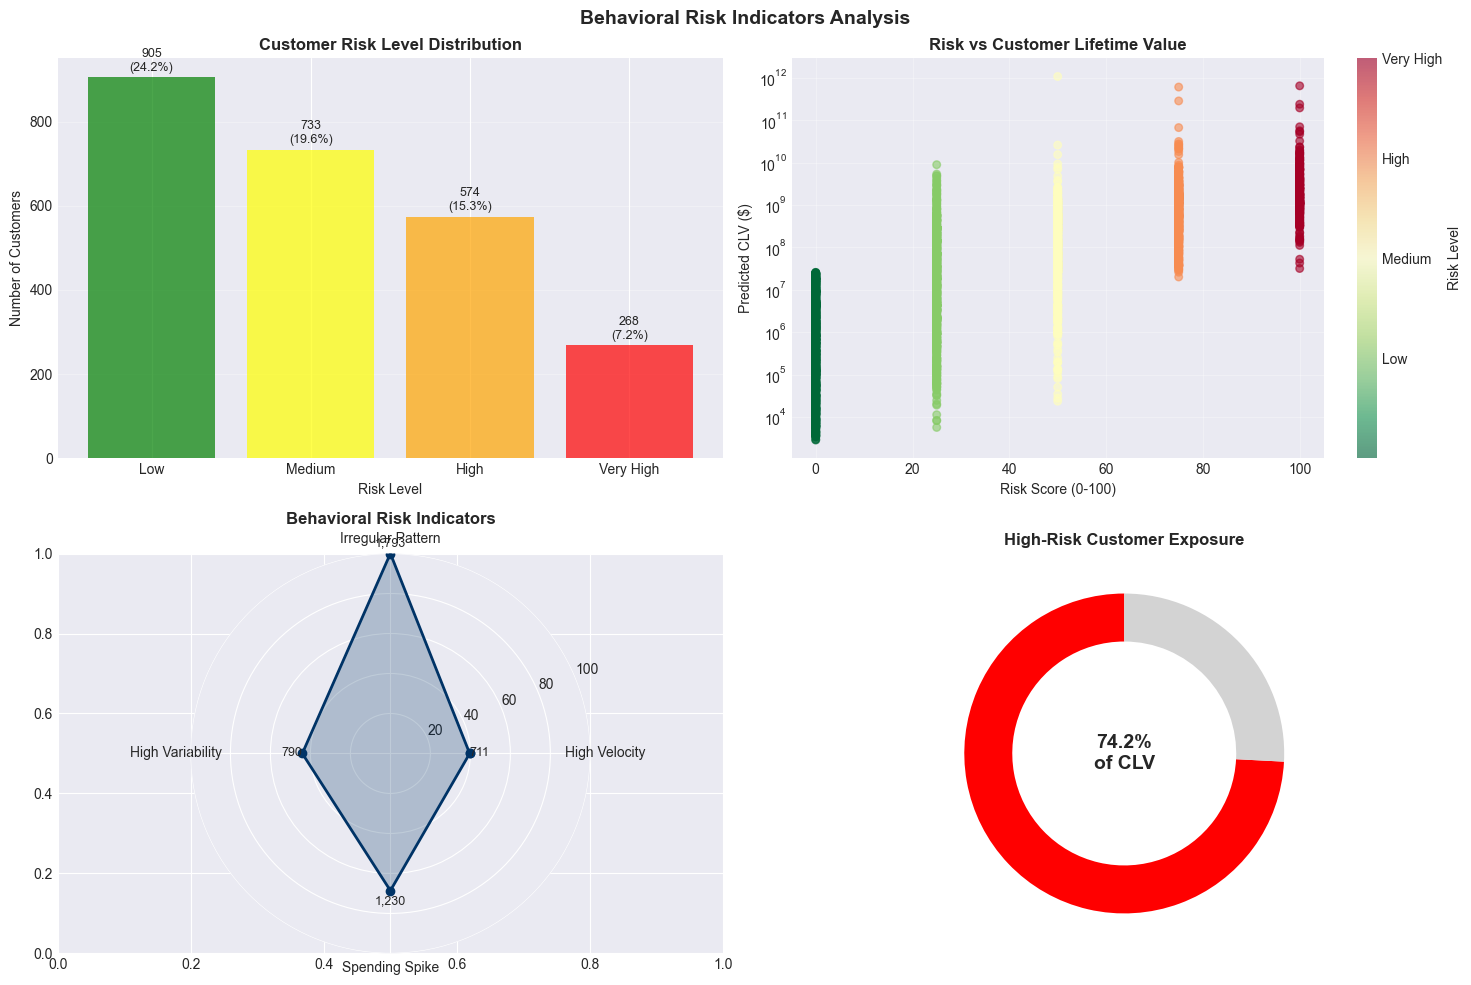

In [10]:
# %%
print("="*80)
print("BEHAVIORAL RISK INDICATORS")
print("="*80)

def analyze_behavioral_risk(df, rfm_df, clv_data):
    """Analyze behavioral patterns that indicate credit risk"""
    
    print(f"\n🚨 BEHAVIORAL RISK INDICATORS:")
    print("-" * 60)
    
    # Merge all customer data
    customer_data = rfm_df.copy()
    if 'Cluster' in customer_data.columns:
        customer_data = customer_data.merge(clv_data[['CLV_Segment', 'Predicted_CLV']], 
                                          left_index=True, right_index=True, how='left')
    
    # 1. Transaction pattern analysis
    print(f"📊 TRANSACTION PATTERN ANALYSIS:")
    print("-" * 40)
    
    # Calculate transaction consistency
    customer_patterns = df.groupby('CustomerId').agg({
        'TransactionStartTime': ['min', 'max', 'count'],
        'Amount': ['mean', 'std', 'min', 'max']
    })
    
    customer_patterns.columns = ['first_transaction', 'last_transaction', 'transaction_count',
                                'amount_mean', 'amount_std', 'amount_min', 'amount_max']
    
    # Calculate transaction interval statistics
    df_sorted = df.sort_values(['CustomerId', 'TransactionStartTime']).copy()
    df_sorted['time_since_last'] = df_sorted.groupby('CustomerId')['TransactionStartTime'].diff()
    df_sorted['days_since_last'] = df_sorted['time_since_last'].dt.total_seconds() / (24 * 3600)
    
    interval_stats = df_sorted.groupby('CustomerId')['days_since_last'].agg(['mean', 'std', 'min', 'max'])
    interval_stats.columns = ['interval_mean', 'interval_std', 'interval_min', 'interval_max']
    
    customer_data = customer_data.merge(customer_patterns, left_index=True, right_index=True, how='left')
    customer_data = customer_data.merge(interval_stats, left_index=True, right_index=True, how='left')
    
    # 2. Identify risky behavioral patterns
    print(f"\n🔍 RISKY BEHAVIORAL PATTERNS:")
    print("-" * 40)
    
    risk_indicators = {}
    
    # Pattern 1: High transaction velocity
    customer_data['daily_transactions'] = customer_data['transaction_count'] / customer_data['Recency']
    high_velocity = customer_data[customer_data['daily_transactions'] > 5]
    risk_indicators['high_velocity'] = len(high_velocity)
    
    if len(high_velocity) > 0:
        print(f"• High Transaction Velocity: {len(high_velocity):,} customers")
        print(f"  Average: {high_velocity['daily_transactions'].mean():.1f} transactions/day")
        print(f"  Risk: Potential fraud or cash flow issues")
    
    # Pattern 2: Irregular transaction intervals
    customer_data['interval_cv'] = customer_data['interval_std'] / customer_data['interval_mean']
    irregular_pattern = customer_data[(customer_data['interval_cv'] > 1.5) & (customer_data['transaction_count'] > 5)]
    risk_indicators['irregular_pattern'] = len(irregular_pattern)
    
    if len(irregular_pattern) > 0:
        print(f"• Irregular Transaction Patterns: {len(irregular_pattern):,} customers")
        print(f"  Average CV: {irregular_pattern['interval_cv'].mean():.2f}")
        print(f"  Risk: Unpredictable behavior, may indicate financial stress")
    
    # Pattern 3: High amount variability
    customer_data['amount_cv'] = customer_data['amount_std'] / customer_data['amount_mean']
    high_variability = customer_data[(customer_data['amount_cv'] > 2) & (customer_data['transaction_count'] > 3)]
    risk_indicators['high_variability'] = len(high_variability)
    
    if len(high_variability) > 0:
        print(f"• High Amount Variability: {len(high_variability):,} customers")
        print(f"  Average CV: {high_variability['amount_cv'].mean():.2f}")
        print(f"  Risk: Inconsistent spending patterns")
    
    # Pattern 4: Recent high spending increase
    # Calculate spending trend (simplified: last 30 days vs previous)
    df_recent = df[df['TransactionStartTime'] > (df['TransactionStartTime'].max() - pd.Timedelta(days=60))]
    df_recent['period'] = np.where(df_recent['TransactionStartTime'] > (df['TransactionStartTime'].max() - pd.Timedelta(days=30)),
                                  'recent', 'previous')
    
    spending_trend = df_recent.groupby(['CustomerId', 'period'])['Amount'].sum().unstack(fill_value=0)
    spending_trend['spending_change_pct'] = ((spending_trend['recent'] - spending_trend['previous']) / 
                                            spending_trend['previous'].replace(0, 1)) * 100
    
    high_increase = spending_trend[spending_trend['spending_change_pct'] > 200]
    risk_indicators['spending_spike'] = len(high_increase)
    
    if len(high_increase) > 0:
        print(f"• Recent Spending Spikes: {len(high_increase):,} customers")
        print(f"  Average increase: {high_increase['spending_change_pct'].mean():.0f}%")
        print(f"  Risk: Sudden lifestyle changes or potential fraud")
    
    # 3. Risk scoring
    print(f"\n🎯 CUSTOMER RISK SCORING:")
    print("-" * 40)
    
    # Calculate risk score (0-100, higher = riskier)
    customer_data['risk_score'] = 0
    
    # Add risk points for each indicator
    if 'high_velocity' in risk_indicators:
        customer_data.loc[customer_data['daily_transactions'] > 5, 'risk_score'] += 25
    
    if 'irregular_pattern' in risk_indicators:
        customer_data.loc[(customer_data['interval_cv'] > 1.5) & (customer_data['transaction_count'] > 5), 'risk_score'] += 25
    
    if 'high_variability' in risk_indicators:
        customer_data.loc[(customer_data['amount_cv'] > 2) & (customer_data['transaction_count'] > 3), 'risk_score'] += 25
    
    # Add points for high CLV customers (higher exposure)
    if 'CLV_Segment' in customer_data.columns:
        customer_data.loc[customer_data['CLV_Segment'].isin(['High', 'Very High']), 'risk_score'] += 25
    
    # Categorize risk levels
    customer_data['risk_level'] = pd.cut(customer_data['risk_score'],
                                        bins=[0, 25, 50, 75, 100],
                                        labels=['Low', 'Medium', 'High', 'Very High'])
    
    risk_distribution = customer_data['risk_level'].value_counts().sort_index()
    
    print(f"Risk Level Distribution:")
    for level, count in risk_distribution.items():
        pct = count / len(customer_data) * 100
        print(f"  {level}: {count:,} customers ({pct:.1f}%)")
    
    # 4. High-risk customer analysis
    high_risk_customers = customer_data[customer_data['risk_level'].isin(['High', 'Very High'])]
    
    if len(high_risk_customers) > 0:
        print(f"\n⚠️ HIGH-RISK CUSTOMER ANALYSIS:")
        print("-" * 40)
        print(f"Total high-risk customers: {len(high_risk_customers):,}")
        print(f"Total exposure: ${high_risk_customers['Monetary'].sum():,.0f}")
        print(f"Average CLV: ${high_risk_customers['Predicted_CLV'].mean():,.2f}")
        
        # Top risk factors
        print(f"\nTop Risk Factors:")
        risk_factors = []
        if len(high_velocity) > 0:
            risk_factors.append(('High Velocity', len(high_velocity.merge(high_risk_customers, left_index=True, right_index=True))))
        if len(irregular_pattern) > 0:
            risk_factors.append(('Irregular Patterns', len(irregular_pattern.merge(high_risk_customers, left_index=True, right_index=True))))
        if len(high_variability) > 0:
            risk_factors.append(('High Variability', len(high_variability.merge(high_risk_customers, left_index=True, right_index=True))))
        
        for factor, count in sorted(risk_factors, key=lambda x: x[1], reverse=True):
            print(f"  • {factor}: {count:,} high-risk customers")
    
    return customer_data, risk_indicators

# Analyze behavioral risk
customer_data, risk_indicators = analyze_behavioral_risk(df, rfm_df, clv_data)

# Create risk visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Risk level distribution
risk_distribution = customer_data['risk_level'].value_counts().sort_index()
colors = ['green', 'yellow', 'orange', 'red']

bars = axes[0, 0].bar(risk_distribution.index.astype(str), risk_distribution.values,
                     color=colors, alpha=0.7)
axes[0, 0].set_xlabel('Risk Level')
axes[0, 0].set_ylabel('Number of Customers')
axes[0, 0].set_title('Customer Risk Level Distribution', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

# Add value labels
for bar, count in zip(bars, risk_distribution.values):
    height = bar.get_height()
    pct = count / len(customer_data) * 100
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + max(risk_distribution.values)*0.01,
                   f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=9)

# 2. Risk vs CLV scatter
if 'Predicted_CLV' in customer_data.columns:
    scatter = axes[0, 1].scatter(customer_data['risk_score'], customer_data['Predicted_CLV'],
                                c=customer_data['risk_level'].cat.codes, s=30, alpha=0.6,
                                cmap='RdYlGn_r')
    axes[0, 1].set_xlabel('Risk Score (0-100)')
    axes[0, 1].set_ylabel('Predicted CLV ($)')
    axes[0, 1].set_title('Risk vs Customer Lifetime Value', fontsize=12, fontweight='bold')
    axes[0, 1].set_yscale('log')
    axes[0, 1].grid(alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=axes[0, 1])
    cbar.set_ticks([0, 1, 2, 3])
    cbar.set_ticklabels(['Low', 'Medium', 'High', 'Very High'])
    cbar.set_label('Risk Level')

# 3. Risk indicators radar chart
if risk_indicators:
    categories = list(risk_indicators.keys())
    values = [risk_indicators[cat] for cat in categories]
    
    # Normalize values for radar chart
    max_value = max(values) if values else 1
    normalized_values = [v / max_value * 100 for v in values]
    
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
    normalized_values += normalized_values[:1]
    angles += angles[:1]
    
    ax = plt.subplot(2, 2, 3, polar=True)
    ax.plot(angles, normalized_values, 'o-', linewidth=2, color=corporate_colors[0])
    ax.fill(angles, normalized_values, alpha=0.25, color=corporate_colors[0])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([cat.replace('_', ' ').title() for cat in categories])
    ax.set_ylim(0, 100)
    ax.set_title('Behavioral Risk Indicators', fontsize=12, fontweight='bold')
    ax.grid(True)
    
    # Add value labels
    for angle, value, orig_value in zip(angles[:-1], normalized_values[:-1], values):
        ax.text(angle, value + 5, f'{orig_value:,}', ha='center', va='center', fontsize=9)

# 4. High-risk customer exposure
if 'Predicted_CLV' in customer_data.columns:
    high_risk_mask = customer_data['risk_level'].isin(['High', 'Very High'])
    high_risk_exposure = customer_data[high_risk_mask]['Predicted_CLV'].sum()
    total_exposure = customer_data['Predicted_CLV'].sum()
    exposure_pct = high_risk_exposure / total_exposure * 100
    
    # Create donut chart
    sizes = [high_risk_exposure, total_exposure - high_risk_exposure]
    colors = ['red', 'lightgray']
    
    axes[1, 1].pie(sizes, colors=colors, startangle=90, wedgeprops=dict(width=0.3))
    axes[1, 1].text(0, 0, f'{exposure_pct:.1f}%\nof CLV', ha='center', va='center',
                   fontsize=14, fontweight='bold')
    axes[1, 1].set_title('High-Risk Customer Exposure', fontsize=12, fontweight='bold')

plt.suptitle('Behavioral Risk Indicators Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../../reports/task2_eda/visualizations/customer_behavior/risk_indicators.png', 
            dpi=300, bbox_inches='tight')
plt.show()